In [1]:
import importlib
import time

import numpy as np

import wumpus
import aufgabe2
import aufgabe2_mike
import aufgabe2_friend
import agents

In [2]:
def render_one_episode(agent: agents.AgentV2, env: wumpus.Wumpus):
    import time
    agent.new_episode()

    terminated = False
    percept = env.reset()
    total_reward = 0
    reward = 0
    while not terminated:
        action = agent.get_action(percept, reward)
        display(env.render(), clear=True)
        print(action)
        time.sleep(0.5)
        percept, reward, terminated, info = env.step(action)
        total_reward += reward
    print(f"episode finished with reward {total_reward}")

def test_agent(
    agent: agents.AgentV2,
    env: wumpus.Wumpus,
    n_repeat = 100,
    return_full = False,
):
    cum_rewards = np.zeros(n_repeat)

    for run in range(n_repeat):
        agent.new_episode()
        terminated = False
        percept = env.reset()
        reward = 0
        while not terminated:
            action = agent.get_action(percept, reward)
            percept, reward, terminated, info = env.step(action)
            cum_rewards[run] += reward

    if return_full:
        return cum_rewards
    average_total_reward = np.mean(cum_rewards)
    return average_total_reward


In [3]:
importlib.reload(aufgabe2)
importlib.reload(aufgabe2_mike)
size = (4, 4)
env = wumpus.Wumpus(seed=2025, size=size, p_pit=0.)

# agent = agents.AgentV2(size=size)
# agent = aufgabe2.Agent(size=size)
# agent = aufgabe2_friend.Agent(size=size)
agent = aufgabe2_mike.Agent(size=size)

In [42]:
test_agent(agent, env)

-1059.0

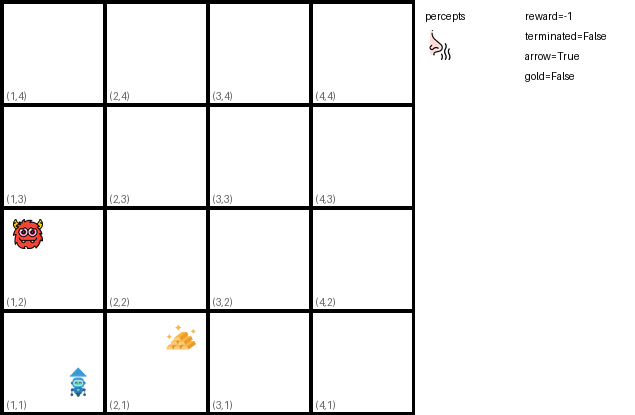

1
episode finished with reward -1049


In [17]:
render_one_episode(agent, env)

In [15]:
import importlib
import numpy as np
import aufgabe2_mike
importlib.reload(aufgabe2_mike)

import stable_baselines3
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

def export_ppo_to_string(agent: stable_baselines3.PPO, dtype=np.float32):
    import itertools

    weights = []
    biases = []

    iter1 = agent.policy.get_submodule("mlp_extractor").get_submodule("policy_net").named_children()
    iter2 = agent.policy.get_submodule("action_net").named_modules()
    for name, param in itertools.chain(iter1, iter2):
        # print(name, param)
        for p in param.parameters():
            m = p.detach().numpy().transpose()
            m = m.astype(dtype=dtype)
            if len(m.shape) == 2:
                weights.append(m)
            elif len(m.shape) == 1:
                biases.append(m)

    layers = [w.shape[1] for w in weights[:-1]]
    input_dim = weights[0].shape[0]
    output_dim = weights[-1].shape[1]

    net = aufgabe2_mike.NeuralNetwork(input_dim, output_dim, layers)
    net.weights = weights
    net.biases = biases

    return net.to_string()

def save_to_clipboard(text: str):
    import os
    command = 'echo | set /p nul=' + text.strip() + '| clip'
    os.system(command)

def render_one_episode_gym(
    agent: stable_baselines3.PPO, env: aufgabe2_mike.WumpusEnv, deterministic=True
):
    import time
    done = False
    total_reward = 0
    obs, _ = env.reset()
    for i in range(1000):
        display(env.render(), clear=True)
        a = agent.predict(obs, deterministic=deterministic)[0]
        print(a)
        time.sleep(0.5)
        obs, r, done, _, _ = env.step(a)
        total_reward += r
        if done:
            break
    print(f"Episode done. Total reward: {total_reward:.2f}")

size = (4, 4)
p_pit = 0.
with_wumpus = True
time_max = 100

env_fn_easy_v1 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0., seed=None, Tmax=time_max, with_wumpus=False,
))
env_fn_easy_v2 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0., seed=None, with_wumpus=False, Tmax=(15, 100), start_orientation=None,
))
env_fn_easy_v3 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0., seed=None, Tmax=(90, 100), with_wumpus=False, start_pos=None, start_orientation=None
))
env_fn_easy_v4 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0., seed=None, Tmax=(15, 100), with_wumpus=False, start_pos=None, start_orientation=None
))

env_fn_medium_v1 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0., seed=None, Tmax=time_max, with_wumpus=True, #start_pos=None, start_orientation=None
))
env_fn_medium_v2 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0., seed=None, Tmax=(40, 81), with_wumpus=True, start_orientation=None,
))

env_fn_hard_v1 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0.05, seed=None, Tmax=time_max, with_wumpus=False,
))
env_fn_hard_v2 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=(0.05, 0.20), seed=None, Tmax=(40, 100), with_wumpus=False,
))

env_fn_expert_v1 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0.05, seed=None, Tmax=time_max, with_wumpus=True, #start_pos=None, start_orientation=None
))
env_fn_expert_v2 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=(0.05, 0.20), seed=None, Tmax=(40, 100), with_wumpus=True, start_orientation=None,
))
env_fn_expert_v3 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=(0.0, 0.25), seed=None, Tmax=(40, 100), with_wumpus=True, start_orientation=None,
))

env_fn_validation = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0.20, seed=None, Tmax=50,
))

In [16]:
importlib.reload(aufgabe2_mike)
# vec_env = make_vec_env(env_fn_easy, n_envs=64)
# vec_env = DummyVecEnv([env_fn_easy_v1] * 16 + [env_fn_medium_v1] * 48) #
# vec_env = DummyVecEnv([env_fn_easy_v2] * 32 + [env_fn_medium_v1] * 96) #
# vec_env = DummyVecEnv([env_fn_easy_v2] * 32 + [env_fn_medium_v1] * 92 + [env_fn_hard_v1] * 4) # 
# vec_env = DummyVecEnv([env_fn_easy_v2] * 16 + [env_fn_medium_v2] * 92 + [env_fn_expert_v1] * 20) #
# vec_env = DummyVecEnv([env_fn_easy_v2] * 16 + [env_fn_medium_v2] * 64 + [env_fn_expert_v2] * 48) 
vec_env = DummyVecEnv([env_fn_easy_v2] * 16 + [env_fn_medium_v2] * 8 + [env_fn_expert_v3] * 104)

In [ ]:
env = env_fn_expert_v3()
env.reset()
env.step(0)
env.step(0)

In [ ]:
import torch
policy_kwargs = dict(
    net_arch=[256,256],
    activation_fn=torch.nn.Tanh,                     
    optimizer_class=torch.optim.AdamW,
    optimizer_kwargs=dict(weight_decay=2e-2),
    # optimizer_class=torch.optim.SGD,
    # optimizer_kwargs=dict(weight_decay=0e-4, momentum=0.9, nesterov=True),
)
agent = stable_baselines3.PPO(
    "MlpPolicy",
    vec_env,
    learning_rate=1e-3,
    batch_size = 512,
    ent_coef=0.03,
    verbose=1,
    stats_window_size=1000,
    policy_kwargs=policy_kwargs,
)

Using cpu device


In [ ]:
torch.set_num_threads(2)
agent.learn(total_timesteps=10_000_000, log_interval=1)

In [5]:
# when you want to switch optimizer (copies weights only w/o optimizer state)
proxy_model = stable_baselines3.PPO.load("ppo_sgd_4", env=vec_env)
agent.policy.load_state_dict(proxy_model.policy.state_dict())

<All keys matched successfully>

In [104]:
# agent.save("ppo_adamw_256")
# agent.save("ppo_sgd_256")
agent = stable_baselines3.PPO.load("ppo_sgd_128", env=vec_env)
# agent.set_parameters("ppo_sgd_5")
# from pandas.io import clipboard
# clipboard.copy(f'"{export_ppo_to_string(agent, np.float16)}"')

In [32]:
importlib.reload(aufgabe2_mike)
# vec_env_ = vec_env
# vec_env_ = DummyVecEnv([env_fn_easy_v2] * 64 + [env_fn_medium_v2] * 0 + [env_fn_expert_v3] * 0)
env_fn = lambda: aufgabe2_mike.WumpusEnv(size=(4,4), p_pit=0., seed=None, with_wumpus=True)
vec_env_ = make_vec_env(env_fn, n_envs=64)
mean, std = stable_baselines3.common.evaluation.evaluate_policy(
    agent, vec_env_, n_eval_episodes=5_000, deterministic=False
)
print(f"{mean:.2f} +/- {std:.2f}")

101.60 +/- 30.80


In [7]:
env_fn = lambda: aufgabe2_mike.WumpusEnv(size=(4,4), p_pit=0., seed=None, with_wumpus=True)
vec_env_ = make_vec_env(env_fn, n_envs=64)
for i in range(100):
    try:
        agent.set_parameters(f"ppo_sgd_{i+1}")
        mean, std = stable_baselines3.common.evaluation.evaluate_policy(
            agent, vec_env_, n_eval_episodes=10_000, deterministic=False
        )
        print(f"{i+1:3}  r = {mean:.2f} +/- {std:.2f}")
    except:
        break

  1  r = 95.93 +/- 41.45
  2  r = 96.70 +/- 40.40
  3  r = 97.08 +/- 39.97
  4  r = 97.25 +/- 39.92


In [8]:
env_fn = lambda: aufgabe2_mike.WumpusEnv(size=(4,4), p_pit=0.2, seed=None, with_wumpus=True)
vec_env_ = make_vec_env(env_fn, n_envs=64)
for i in range(100):
    try:
        agent.set_parameters(f"ppo_sgd_{i+1}")
        mean, std = stable_baselines3.common.evaluation.evaluate_policy(
            agent, vec_env_, n_eval_episodes=50_000, deterministic=False
        )
        print(f"{i+1:3}  r = {mean:.2f} +/- {std:.2f}")
    except:
        break
# 25.2
# ~26.5 -> 27.0 max
# 27.0
# 27.5
# 33.5

  1  r = 28.40 +/- 52.79
  2  r = 28.67 +/- 52.86
  3  r = 28.57 +/- 52.97
  4  r = 28.71 +/- 52.93


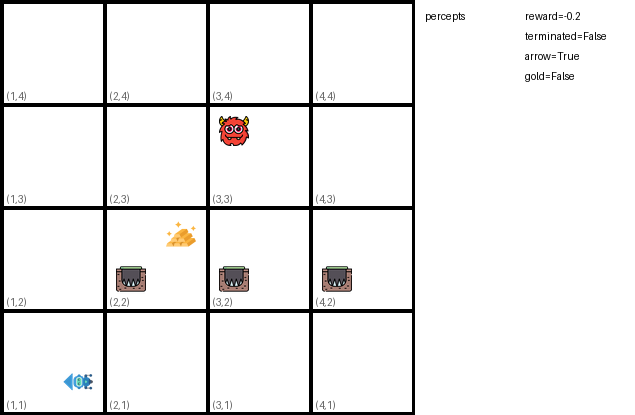

5
Episode done. Total reward: -2.80


In [105]:
importlib.reload(aufgabe2_mike)
# 6
# env = aufgabe2_mike.WumpusEnv(seed=6)
# env = env_fn_hard_v1()
env = aufgabe2_mike.WumpusEnv(size=(4,4), p_pit=0.20, seed=None, with_wumpus=True, Tmax=50)
render_one_episode_gym(agent, env, deterministic=False)

In [28]:
# check model weights norm
weights_norm = []
for param in agent.policy.parameters():
    try:
        weights_norm.append(torch.norm(param).item())
    except:
        pass
print(sum(weights_norm))
# 147
# 176
# 171
# 167

# SGD:
# 175
# 177
# 175-185
# 185-190
# 191-202

202.6596496105194


In [ ]:
for i in range(100):
    try:
        agent.set_parameters(f"ppo_sgd_{i+1}")
        weights_norm = []
        for param in agent.policy.parameters():
            try:
                weights_norm.append(torch.norm(param).item())
            except:
                pass
        print(sum(weights_norm))
    except:
        break